# CORA & GraphSAGE

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import collections
import copy
from tqdm import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
import torch_scatter
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid
from torch_geometric.nn.conv import MessagePassing

## Подгрузка датасета

In [3]:
dataset = Planetoid(root="./data/cora", name="Cora")
dataset

Cora()

In [4]:
data = dataset[0]

Число узлов

In [6]:
data.num_nodes

2708

Число ребер

In [7]:
data.num_edges

10556

In [8]:
data.is_undirected()

True

Количество ребер в два раза превышает фактическое количество так как мы храним оба направления для неориентированного графа

In [9]:
data.num_edges / 2.

5278.0

Число признаков

In [10]:
data.num_features

1433

In [11]:
print(len(data.x[0]))
data.x[0][:50]

1433


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Классы

In [12]:
dataset.num_classes

7

In [13]:
data.y[:10]

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2])

Посмотрим на распределение классов

{3: 818, 4: 426, 0: 351, 2: 418, 1: 217, 5: 298, 6: 180}


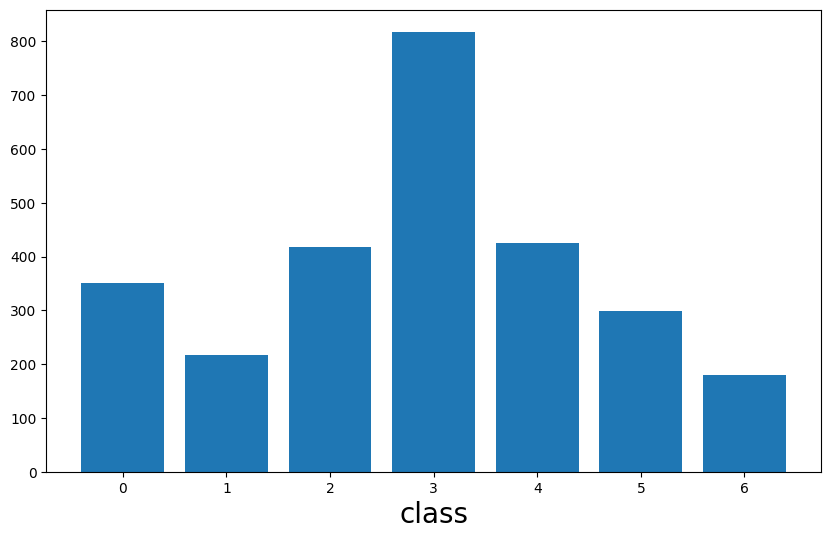

In [14]:
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(10, 6))
plt.bar(range(7), count)
plt.xlabel("class", size=20)
plt.show()

## Реализация основного модуля

Ниже приведена реализация основного модуля GNN.

In [15]:
class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GraphSage(input_dim, hidden_dim))
        assert args.num_layers >= 1, "Число сверточных слоев должно быть >=1"
        for l in range(args.num_layers - 1):
            self.convs.append(GraphSage(args.heads * hidden_dim, hidden_dim))

        # обработка после сверток полносвязными слоями
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim),
            nn.Dropout(args.dropout),
            nn.Linear(hidden_dim, output_dim),
        )

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

## Реализация Message Passing

Для реализации Message Passing сверток GraphSage разработаем 3 функции, необходимые для передачи и обработки сообщений: `forward`, `message`, и `aggregate`.

Функция `propagate` инкапсулирует процесс передачи сообщения. Она делает это, вызывая три функции: 1) `message`, 2)  `aggregate`, и 3) `update`. Здесь мы не будем явно реализовывать `update`, а вместо этого поместим логику для обновления эмбеддингов узлов после передачи сообщения внутри функции `forward`. После передачи сообщения мы можем дополнительно преобразовать эмбеддинги узлов, полученные с помощью `propagate`. И так, выходы из `forward` — это эмбеддинги вершин после одного слоя GNN.


Теперь подробнее:

1.

```
def propagate(edge_index, x=(x_v, x_w), extra=(extra_v, extra_w), size=size):
```
Вызов `propagate` инициирует процесс передачи сообщения.

   - `edge_index` передается `forward` функции и получает структуру ребер графа.
   - `x=(x_v, x_w)` представляет эмбеддинги вершин, которые будут использоваться при передаче сообщений, $v$ центральный узел ($x_{central}$) и $w$ -- это соседний узел ($x_{neighbor}$).
   
Для центрального узла $v$ мы будем агрегировать и преобразовывать все сообщения, связанные с его соседними узлами $w$  $(v, w) \in \mathcal{E}$ ($w \in \mathcal{N}_{v}$). Индексы `_v` и `_w` позволяют нам различать эмбеддинги, связанные с центральными узлами (т. е. узлами, получающими информацию о сообщениях) и соседними узлами (т. е. узлами, передающими сообщения).

Но в разные моменты узел $x$ действует как центральный узел, так и соседний узел. В неориентированных графах мы храним оба направления ребер (т. е. $(v, w)$ и $(w, v)$). С точки зрения центрального узла, `x_v`, $x$ собирает соседнюю информацию для обновления своего внутреннего состояния. С точки зрения соседнего узла, `x_w`, $x$ передает сообщение другому центральному узлом.

  - `extra=(extra_v, extra_w)` представляет дополнительную информацию, которую мы можем связать с каждым узлом помимо его текущего состояния. На самом деле, мы можем включить столько дополнительных параметров вида `param=(param_v, param_w)`, сколько захотим.

  Выход функции `propagate` представляет собой матрицу эмбеддингов вершин после процесса передачи сообщения и имеет размерность $N \times d$, где $N$ -- число вершин `size`, $d$ -- размер эмбеддинга.

2.
```
def message(x_w, ...):
```
Функция `message` вызывается функцией `propagate` и создает сообщения из соседних вершин $w$ с центральными узлами $v$ для каждого ребра $(v, w)$ в *edge_index*. Эта функция может принимать любой аргумент, который изначально был передан в функцию `propagate`.

   - `x_w` представляет собой матрицу эмбеддингов признаков для всех соседних узлов, передающих свои сообщения по соответствующему ребру (т. е. все узлы $w$ для рёбер $(v, w) \in \mathcal{E}$). Таким образом, ее размерность равна $|\mathcal{E}| \times d $

  Выходом `message` функции является матрица эмбеддингов соседних узлов размерностью $|\mathcal{E}| \times d$ -> на вход `aggregate`.

3.
```
def aggregate(inputs, index, dim_size = None):
```
Наконец, функция `aggregate` используется для агрегирования сообщений из соседних вершин:

   - `inputs` представляют собой матрицу сообщений, переданных из соседних узлов (т.е. выход функции `message`).
   - `index` имеет ту же форму, что и `inputs`, и сообщает нам центральный узел, соответствующий каждой из строк/сообщению $w$ в матрице `inputs`. Таким образом, `index` говорит нам, какие строки/сообщения агрегировать для каждого центрального узла.

   Выход `aggregate` имеет размерность $N \times d$.

Теперь реализуем свой слой GraphSage.

Для данного *центрального* узла $v$ с текущим эмбеддингом $x_v^{t}$ правило обновления передачи сообщений для преобразования $x_v^{t} \rightarrow x_v^{t+1}$ выглядит следующим образом:

\begin{equation}
x_v^{(t + 1)} = W_1\cdot x_v^{(t)} + W_2 \cdot A(\{x_w^{(t)}, \forall w \in \mathcal{N}_v \})
\end{equation}

где $W_1$ и $W_2$ — обучаемые матрицы весов, а узлы $w$ — *соседние* узлы. Кроме того, для простоты используем среднее агрегирование:

\begin{equation}
A(\{x_w^{(t)}, \forall w \in \mathcal{N}_v \}) = \frac{1}{|\mathcal{N}_v|} \sum_{w\in \mathcal{N}_v} x_w^{(t)}
\end{equation}

Добавляем skip connections в эту реализацию GraphSage через $W_1\cdot x_v^{(t)}$. Также после каждой итерации применяется $L_2$ нормализация (по умолчанию `normalize=True`) эмбеддингов вершин.

In [26]:
class GraphSage(MessagePassing):
    # метод self.propagate не переопределен и берется из родительского
    def __init__(self, in_channels, out_channels, normalize=True, bias=False, **kwargs):
        super().__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = torch.nn.Linear(in_channels, out_channels, bias=bias)
        self.lin_r = torch.nn.Linear(in_channels, out_channels, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size=None):
        neighbor_out = self.propagate(edge_index, x=(x, x), size=size)
        out = self.lin_l(x) + self.lin_r(neighbor_out)
        if self.normalize:
            out = torch.nn.functional.normalize(out, p=2)
        return out

    def message(self, x_j):
        out = x_j
        return out

    def aggregate(self, inputs, index):
        out = torch_scatter.scatter(inputs, index, dim=self.node_dim, reduce="mean")
        return out

### Обучение GNN

In [27]:
def train(dataset, args):
    print("Train set size: ", np.sum(dataset[0]["train_mask"].numpy()))
    print("Val set size: ", np.sum(dataset[0]["val_mask"].numpy()))
    print()
    loader = DataLoader(
        dataset, batch_size=args.batch_size, shuffle=True
    )
    test_loader = DataLoader(
        dataset, batch_size=args.batch_size, shuffle=False
    )

    # построение модели
    model = GNNStack(
        dataset.num_node_features, args.hidden_dim, dataset.num_classes, args
    )
    filter_fn = filter(lambda p: p.requires_grad, model.parameters())
    opt = optim.Adam(filter_fn, lr=args.lr, weight_decay=args.weight_decay)
    if args.summary:
        new_loader = iter(loader)
        b = next(new_loader)
        print(torch_geometric.nn.summary(model, b))

    # train
    losses = []
    val_accs = []
    best_acc = 0
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
            val_acc = test(test_loader, model)
            val_accs.append(val_acc)
            if val_acc > best_acc:
                best_acc = val_acc
                best_model = copy.deepcopy(model)
        else:
            val_accs.append(val_accs[-1])

    return val_accs, losses, best_model, best_acc, test_loader


def test(loader, test_model, is_validation=True, save_model_preds=False):
    if not is_validation:
        print("Test set size: ", np.sum(dataset[0]["test_mask"].numpy()))
        print()
    test_model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            # max(dim=1) возвращает кортеж (values, indices); нужны только indices
            pred = test_model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        pred = pred[mask]
        label = label[mask]

        if save_model_preds:
            data = {}
            data["pred"] = pred.view(-1).cpu().detach().numpy()
            data["label"] = label.view(-1).cpu().detach().numpy()

            df = pd.DataFrame(data=data)
            df.to_csv("./models/CORA-model-preds.csv", index=False)

        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()

    return correct / total


class ObjectView(object):
    def __init__(self, d):
        self.__dict__ = d

In [28]:
args = {
    "num_layers": 3,
    "heads": 1,
    "batch_size": 32,
    "hidden_dim": 32,
    "dropout": 0.5,
    "epochs": 500,
    "weight_decay": 5e-3,
    "lr": 0.01,
    "summary": True
}

In [29]:
args = ObjectView(args)

Train set size:  140
Val set size:  500

+-----------------------+--------------------------+----------------+----------+
| Layer                 | Input Shape              | Output Shape   | #Param   |
|-----------------------+--------------------------+----------------+----------|
| GNNStack              | [2708, 2708]             | [2708, 7]      | 97,095   |
| ├─(convs)ModuleList   | --                       | --             | 95,808   |
| │    └─(0)GraphSage   | [2708, 1433], [2, 10556] | [2708, 32]     | 91,712   |
| │    └─(1)GraphSage   | [2708, 32], [2, 10556]   | [2708, 32]     | 2,048    |
| │    └─(2)GraphSage   | [2708, 32], [2, 10556]   | [2708, 32]     | 2,048    |
| ├─(post_mp)Sequential | [2708, 32]               | [2708, 7]      | 1,287    |
| │    └─(0)Linear      | [2708, 32]               | [2708, 32]     | 1,056    |
| │    └─(1)Dropout     | [2708, 32]               | [2708, 32]     | --       |
| │    └─(2)Linear      | [2708, 32]               | [2708, 7]      

Training: 100%|██████████| 500/500 [02:23<00:00,  3.47Epochs/s]


Maximum val accuracy: 0.7720
Minimum train loss: 0.1275


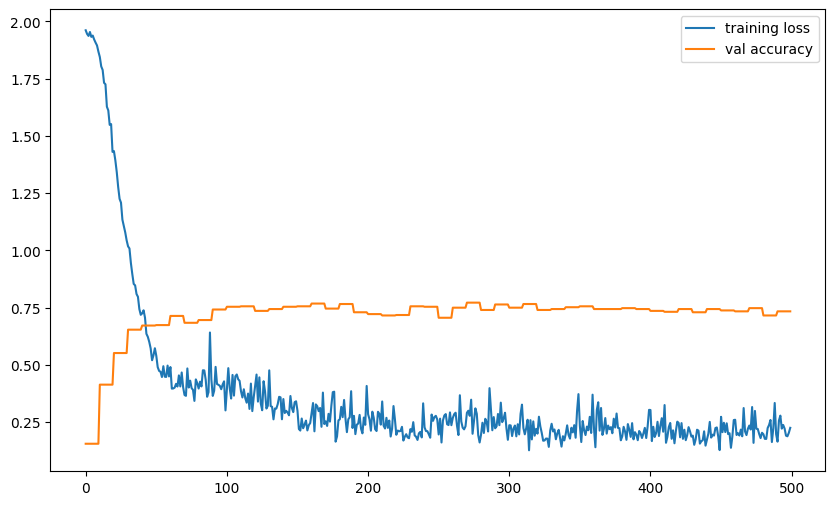

In [30]:
val_accs, losses, best_model, best_acc, test_loader = train(dataset, args)

print(f"Maximum val accuracy: {best_acc:.4f}")
print(f"Minimum train loss: {min(losses):.4f}")

plt.figure(figsize=(10, 6))
plt.plot(losses, label="training loss")
plt.plot(val_accs, label="val accuracy")
plt.legend()
plt.show()

In [32]:
test(
    test_loader,
    best_model,
    is_validation=False,
    save_model_preds=True,
)

Test set size:  1000



0.774